In [1]:
import os
import pickle

import pandas as pd
import scipy
import datetime
import numpy as np
import tensorflow as tf

from definitions import ROOT_DIR

import matplotlib.pyplot as plt
from sklearn import metrics


seed = 2
tf.random.set_seed(seed)
np.random.seed(seed)

import simclr_models
import simclr_utitlities

In [2]:
# Dataset-specific
# working_directory = 'SleepEEG/'
# data_folder = 'SleepEEG'
working_directory = 'MIMIC/'
data_folder = 'MIMIC'
model_name = '20230227-170733_finetuning.hdf5'

In [3]:
# Load preprocessed data
np_train = (np.load(os.path.join(data_folder, 'train_x.npy')),
           np.load(os.path.join(data_folder, 'train_y.npy')))
np_val = (np.load(os.path.join(data_folder, 'val_x.npy')),
           np.load(os.path.join(data_folder, 'val_y.npy')))
np_test = (np.load(os.path.join(data_folder, 'test_x.npy')),
           np.load(os.path.join(data_folder, 'test_y.npy')))

pretrained_model = tf.keras.models.load_model(os.path.join(working_directory, model_name), compile=False)
probs = pretrained_model.predict(np_test[0])

# print(simclr_utitlities.evaluate_model_simple(pretrained_model.predict(np_test[0]), np_test[1], return_dict=True))

In [4]:
predictions = np.argmax(probs,axis=1)

In [5]:
os.chdir(ROOT_DIR)
subjects = pd.read_csv(os.path.join('datasets', data_folder, 'demographics.csv'))
subjects.head()

,SUBJECT_ID,LANGUAGE,INSURANCE,RELIGION,ETHNICITY,GENDER,AGE
0,22,1,1,1,1,0,1
1,23,1,0,1,1,1,0
2,24,1,1,1,1,1,1
3,25,1,1,1,1,1,1
4,26,1,0,1,0,1,0


In [6]:
test_listfile = pd.read_csv(os.path.join('datasets', data_folder, 'test_listfile.csv'))
test_listfile.head()

,stay,y_true
0,10011_episode1_timeseries.csv,1
1,10026_episode1_timeseries.csv,0
2,10030_episode1_timeseries.csv,0
3,10042_episode1_timeseries.csv,0
4,10094_episode1_timeseries.csv,0


In [7]:
# Get subject from test
test_listfile.loc[:, "subject"] = test_listfile.stay.apply(lambda stay: stay.split("_")[0]).astype(int)
test_listfile.head()

,stay,y_true,subject
0,10011_episode1_timeseries.csv,1,10011
1,10026_episode1_timeseries.csv,0,10026
2,10030_episode1_timeseries.csv,0,10030
3,10042_episode1_timeseries.csv,0,10042
4,10094_episode1_timeseries.csv,0,10094


In [8]:
# merge demographics in test df
test_listfile = test_listfile.merge(subjects, left_on="subject", right_on="SUBJECT_ID", how="left")
test_listfile.head()

,stay,y_true,subject,SUBJECT_ID,LANGUAGE,INSURANCE,RELIGION,ETHNICITY,GENDER,AGE
0,10011_episode1_timeseries.csv,1,10011,10011,1,1,1,0,0,1
1,10026_episode1_timeseries.csv,0,10026,10026,1,0,0,1,0,0
2,10030_episode1_timeseries.csv,0,10030,10030,1,0,1,1,1,0
3,10042_episode1_timeseries.csv,0,10042,10042,1,0,1,1,1,0
4,10094_episode1_timeseries.csv,0,10094,10094,1,0,1,0,1,0


In [9]:
print("Test rows with null demograpphics: {} ({}%)".format(test_listfile.SUBJECT_ID.isna().sum(), test_listfile.SUBJECT_ID.isna().sum()/test_listfile.shape[0]))
test_listfile.drop(columns=['SUBJECT_ID'], inplace=True)
test_listfile.head()

Test rows with null demograpphics: 0 (0.0%)


,stay,y_true,subject,LANGUAGE,INSURANCE,RELIGION,ETHNICITY,GENDER,AGE
0,10011_episode1_timeseries.csv,1,10011,1,1,1,0,0,1
1,10026_episode1_timeseries.csv,0,10026,1,0,0,1,0,0
2,10030_episode1_timeseries.csv,0,10030,1,0,1,1,1,0
3,10042_episode1_timeseries.csv,0,10042,1,0,1,1,1,0
4,10094_episode1_timeseries.csv,0,10094,1,0,1,0,1,0


In [10]:
test_listfile.loc[:, "y_predicted"] = predictions
test_listfile.head()

,stay,y_true,subject,LANGUAGE,INSURANCE,RELIGION,ETHNICITY,GENDER,AGE,y_predicted
0,10011_episode1_timeseries.csv,1,10011,1,1,1,0,0,1,0
1,10026_episode1_timeseries.csv,0,10026,1,0,0,1,0,0,0
2,10030_episode1_timeseries.csv,0,10030,1,0,1,1,1,0,0
3,10042_episode1_timeseries.csv,0,10042,1,0,1,1,1,0,0
4,10094_episode1_timeseries.csv,0,10094,1,0,1,0,1,0,0


In [11]:
# Fairness Comparisons conditioned on Insurance Type
print("\n--- Performance on Publicly or Privately Insured Subjects ---")
print(simclr_utitlities.evaluate_model_simple(pretrained_model.predict(np_test[0][test_listfile.INSURANCE == 1]), np_test[1][test_listfile.INSURANCE == 1], return_dict=True))
print("\n--- Performance on Government or Self Insured Subjects ---")
print(simclr_utitlities.evaluate_model_simple(pretrained_model.predict(np_test[0][test_listfile.INSURANCE == 0]), np_test[1][test_listfile.INSURANCE == 0], return_dict=True))


--- Performance on Publicly or Privately Insured Subjects ---
{'Accuracy': 0.9038854805725971, 'AUROC': 0.7410183543643758, 'AUPRC': 0.583643725776953, 'Confusion Matrix': array([[876,  16],
       [ 78,   8]], dtype=int64), 'F1 Macro': 0.5472668176893529, 'F1 Micro': 0.9038854805725971, 'F1 Weighted': 0.8784127189380797, 'Precision': 0.6257861635220126, 'Recall': 0.5375430180415058, 'Kappa': 0.11135599118431727}

--- Performance on Government or Self Insured Subjects ---
{'Accuracy': 0.8680248007085917, 'AUROC': 0.6960395516074449, 'AUPRC': 0.5932200047378028, 'Confusion Matrix': array([[1939,   31],
       [ 267,   21]], dtype=int64), 'F1 Macro': 0.5260846292540005, 'F1 Micro': 0.8680248007085917, 'F1 Weighted': 0.8259508275786213, 'Precision': 0.6414063044842737, 'Recall': 0.5285903130287648, 'Kappa': 0.08794634627687836}


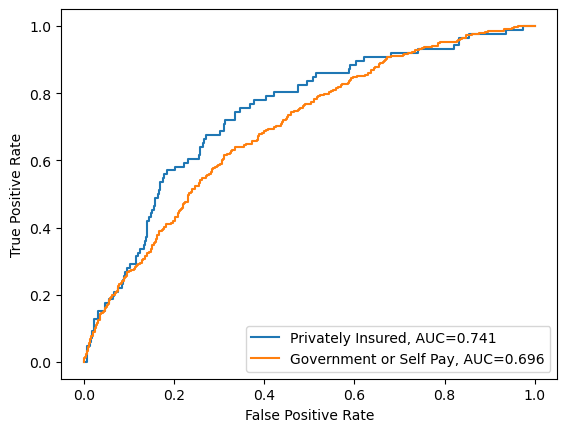

In [13]:
# PRIVATE
fpr, tpr, _ = metrics.roc_curve(
    np_test[1][test_listfile.INSURANCE == 1][:,1],
    pretrained_model.predict(np_test[0][test_listfile.INSURANCE == 1])[:,1]
)
auc = np.round(metrics.roc_auc_score(np_test[1][test_listfile.INSURANCE == 1], pretrained_model.predict(np_test[0][test_listfile.INSURANCE == 1])), 3)
plt.plot(fpr, tpr, label="Privately Insured, AUC="+str(auc))
# GOVERNMENT OR SELF PAY
fpr, tpr, _ = metrics.roc_curve(
    np_test[1][test_listfile.INSURANCE == 0][:,1],
    pretrained_model.predict(np_test[0][test_listfile.INSURANCE == 0])[:,1]
)
auc = np.round(metrics.roc_auc_score(np_test[1][test_listfile.INSURANCE == 0], pretrained_model.predict(np_test[0][test_listfile.INSURANCE == 0])), 3)
plt.plot(fpr, tpr, label="Government or Self Pay, AUC="+str(auc))

#create ROC curve
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()

**Discussion:** The bias assessment really depends on the categorization (split criterion) AND the handling of missing values

In [ ]:
# todo selfhar delta for biases